## Problem Statement
#### Predictions of building electricity usage are needed to aid the Government of the District of Columbia in electricity analysis and budgeting for their buildings.

## SMART Goals
#### Develop a model to predict a given building's electricity usage for each month in 2017 within 10% of the actual usage based on historical data (electricity usage, weather, etc.) from the years 2013-2016.

#### Then add the 2017 historical data to the model's training data to predict the usage for 2018.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

In [2]:
# start-time defined as 1/1/2013 00:00:00 ETC
# start_time = 1357016400
# # start-time defined as 12/31/2017 23:45:00 ETC
# end_time = 1514781900

# for simplicity I'm using UTC, but the above could be used if I wanted to use ETC, which is what the DC Gov't operates under
# start-time defined as 1/1/2013 00:00:00 UTC
start_time = 1356998400
# start-time defined as 12/31/2017 23:45:00 UTC
end_time = 1514763900

# insert (list of) building ID(s)
bldg_ids = [255]

In [3]:
# api function to gather selected buildings electrical usage
def get_bldg_data(bldg):
    temp = requests.get('https://api.newcityenergy.com/v1/buildings/'+str(bldg)+'/interval_data?start_time='+str(start_time)+'&end_time='+str(end_time)+'&data_quality=clean')
    tempdf = pd.DataFrame.from_dict(temp.json(),orient='index')
    tempindex = []
    for x in temp.json().keys():
        x = float(x)
        x = int(x)
        tempindex.append(x)
    tempdf.set_index(pd.DataFrame(tempindex)[0], inplace=True)
    tempdf.rename(columns={0:str(bldg)+'_elec_use'}, inplace=True)
    tempdf.index = pd.to_datetime(tempindex, unit='s')
    tempdf.sort_index(inplace=True)
    return tempdf

In [4]:
# creating dataframe of historical electricity usage for the selected site
bldg_data = pd.DataFrame()
for b in bldg_ids:
    bldg_data = bldg_data.merge(get_bldg_data(b),left_index=True,right_index=True,how='outer')
bldg_data.index.rename('UTC_Datetime', inplace=True)
bldg_data.fillna(0, inplace=True)
bldg_data_day = bldg_data.resample('D').sum()
# ideally I'd create a better way to fill in the missing/0 values with estimated usage based on similar times,
# but it's only about 1% of values, so I've left it out for this version of the project.

In [5]:
# I downloaded historical weather data for Washington, DC and saved it here: Historical_Weather_Data.csv
weather_data = pd.read_csv('Historical_Weather_Data.csv',index_col=0,parse_dates=True)
weather_data = weather_data.fillna(0)
weather_data.index = pd.to_datetime(weather_data.index, unit='s')
# resampling manages when a given hour occurs more than once
weather_data = weather_data.resample('H').mean()

In [6]:
# instantiating weather feature dataframe
weather_features = pd.DataFrame(index=weather_data.index)

In [7]:
# Calculating Heating Degree Days and Cooling Degree Days to quantify heating and cooling needs of the buildings from temp data
# This data is a regression ready way to better represent weather's impacts on heating/cooling electrical use
baseline_temp = 291.483
weather_features['HDD'] = weather_data.temp.apply(lambda x: np.max([(baseline_temp-x)/24,0]))
weather_features['CDD'] = weather_data.temp.apply(lambda x: np.max([(x-baseline_temp)/24,0]))
# 70 F = 294.261
# 65 F = 291.483

In [8]:
# interpolating missing Degree Days. Normally it's just one or a few hours missing at a time, 
# meaning interpolation is an accurate way to fill the values, but occaisionally large time periods are missing,
# meaning interpolating those values is less accurate. A better data source or more complex data filling strategy could be used
# in future versions of this project.
weather_features.interpolate(method='linear',axis=0,inplace=True)

In [9]:
# resampling degree day data. The first line takes the average when a given hour has multiple entries.
# The second line generates daily data.
weather_features = weather_features.resample('D').sum()

In [10]:
weather_features = weather_features['20130101':'20171231']
# weather_features.head()

In [11]:
# I created a csv with:
# a binary for whether a day is an offical DC gov workday (per their website), which should inform occupant electricity use,
# and the minutes of daylight in a given day (from NOAA), which should inform day v night electricity use and capture seasonality
DC_features = pd.read_csv('Historical_Work_Sunlight_Data.csv',index_col=0,parse_dates=True)

In [12]:
# DC_features.head()

In [13]:
# merge onto weather features
features = weather_features.merge(DC_features,left_index=True,right_index=True)

In [14]:
# for testing feature combinations
# features.drop(['HDD'],axis=1,inplace=True)

In [15]:
# features.tail(20)

In [16]:
train_features = features['20130101':'20161231']
test_features = features['20170101':'20171231']
train_target = bldg_data_day['20130101':'20161231']
test_target = bldg_data_day['20170101':'20171231']
feature_cols = train_features.columns

In [17]:
# Since the training data is 4 years, I believe 4 folds without shuffle=True will essentially give me a fold per year
# possibly with a small complication due to 2016 being a leap year
folds = 4

kf = KFold(n_splits=folds)
# if I wanted random folding then: ",random_state=123,shuffle=True"

In [18]:
k_lr = LinearRegression()
k_MAE_scores = []
k_MSE_scores = []
k_RMSE_scores = []
k_R2_scores = []

In [19]:
for train,test in kf.split(train_features):
    # Set up your training and testing sets
    k_x_train = train_features.iloc[train]
    k_x_test = train_features.iloc[test]
    k_y_train = train_target.iloc[train]
    k_y_true = train_target.iloc[test]
    
    # Fit your model on your training x and training y
    k_lr.fit(k_x_train,k_y_train)
    
    # Make Predictions
    k_y_preds = k_lr.predict(k_x_test)
    
    # Score your predictions vs. your true values using mean_squared_error
    k_MAE_fold_score = metrics.mean_absolute_error(k_y_true, k_y_preds)
    k_MSE_fold_score = metrics.mean_squared_error(k_y_true, k_y_preds)
    k_RMSE_fold_score = np.sqrt(metrics.mean_squared_error(k_y_true, k_y_preds))
    k_R2_fold_score = k_lr.score(train_features,train_target)
    
    # Append your score 
    k_MAE_scores.append(k_MAE_fold_score)
    k_MSE_scores.append(k_MSE_fold_score)
    k_RMSE_scores.append(k_RMSE_fold_score)
    k_R2_scores.append(k_R2_fold_score)

In [20]:
print('Mean MAE Scores: ',np.mean(k_MAE_scores))
print('Mean MSE Scores: ',np.mean(k_MSE_scores))
print('Mean RMSE Scores: ',np.mean(k_RMSE_scores))
print('Mean R2 Scores: ',np.mean(k_R2_scores))

Mean MAE Scores:  4256.87658551
Mean MSE Scores:  35122444.4399
Mean RMSE Scores:  5752.29173986
Mean R2 Scores:  0.429302690985


In [21]:
# I played around with the features, and found:
# HDD was important ~.17 R2 impact
# CDD was important ~.16 R2 impact
# Sunlight was important ~.1 R2 impact
# Workday was a little helpful ~.01 R2 impact

In [22]:
lr = LinearRegression()
lr.fit(train_features,train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
test_preds = lr.predict(test_features)

In [24]:
MAE_score = metrics.mean_absolute_error(test_target, test_preds)
MSE_score = metrics.mean_squared_error(test_target, test_preds)
RMSE_score = np.sqrt(metrics.mean_squared_error(test_target, test_preds))
R2_score = lr.score(test_features, test_target)

In [25]:
print('MAE Score: ',MAE_score)
print('MSE Score: ',MSE_score)
print('RMSE Score: ',RMSE_score)
print('R2 Score: ',R2_score)
print('Actual 2017 kWh: ',test_target['255_elec_use'].sum())
print('Pred 2017 kWh: ',test_preds.sum())
print('% Error of Actual v Pred 2017 kWh: ',\
      (test_preds.sum()-test_target['255_elec_use'].sum())/test_target['255_elec_use'].sum())

MAE Score:  3728.49282941
MSE Score:  30113148.7065
RMSE Score:  5487.54487057
R2 Score:  0.0537966297248
Actual 2017 kWh:  7430475.319999994
Pred 2017 kWh:  8246990.91271
% Error of Actual v Pred 2017 kWh:  0.109887397179


Text(0,0.5,'Predicted')

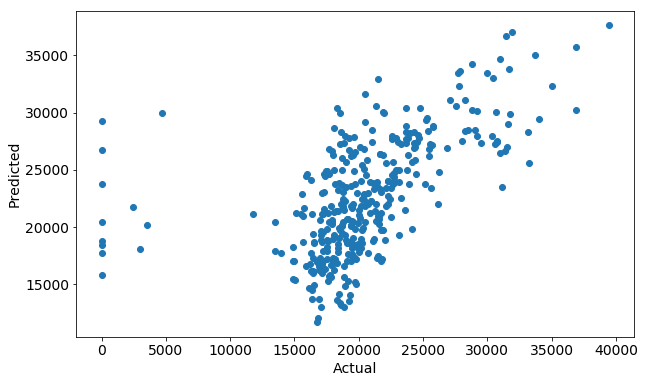

In [26]:
plt.scatter(test_target['255_elec_use'], test_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [27]:
# the data points on the far left have Actual Usage substantially lower than the building's normal usage and are likely
# caused by missing electricty data, which is throwing off the model to a certain extent

In [28]:
test_residuals = test_preds - test_target
# print(test_residuals)

(array([  27.,   85.,  142.,   69.,   26.,    4.,    4.,    4.,    2.,    2.]),
 array([ -7648.39053637,  -3956.83206948,   -265.2736026 ,   3426.28486428,
          7117.84333116,  10809.40179804,  14500.96026493,  18192.51873181,
         21884.07719869,  25575.63566557,  29267.19413245]),
 <a list of 10 Patch objects>)

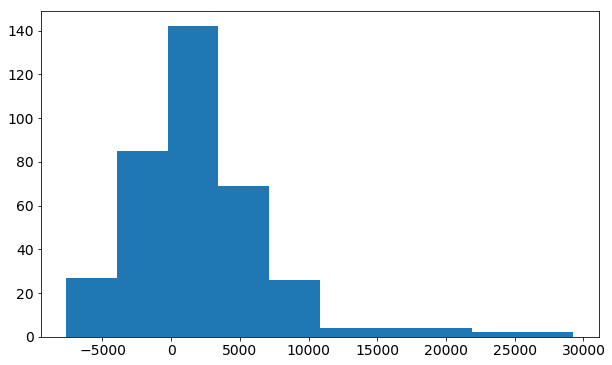

In [29]:
plt.hist(test_residuals['255_elec_use'])

In [30]:
test_preds_df = pd.DataFrame(test_preds,index=test_target.index,columns=['kwh_pred'])
# test_preds_df.head()

In [31]:
test_target_monthly = test_target['255_elec_use'].resample('M').sum()
test_preds_monthly = test_preds_df['kwh_pred'].resample('M').sum()

In [32]:
monthly_residuals = test_preds_monthly - test_target_monthly
monthly_percent_off = ((test_preds_monthly - test_target_monthly) / test_target_monthly) * 100
annual_percent_off = ((test_preds_monthly.sum() - test_target_monthly.sum()) / test_target_monthly.sum()) * 100
print(monthly_percent_off)
print(annual_percent_off)

UTC_Datetime
2017-01-31     9.033187
2017-02-28    -3.999797
2017-03-31    -2.480258
2017-04-30    -2.947552
2017-05-31   -11.762254
2017-06-30     4.894125
2017-07-31     4.090244
2017-08-31    20.264364
2017-09-30    12.216781
2017-10-31    28.514574
2017-11-30    35.724801
2017-12-31    45.600813
Freq: M, dtype: float64
10.988739717855431


Text(0,0.5,'Monthly Residuals')

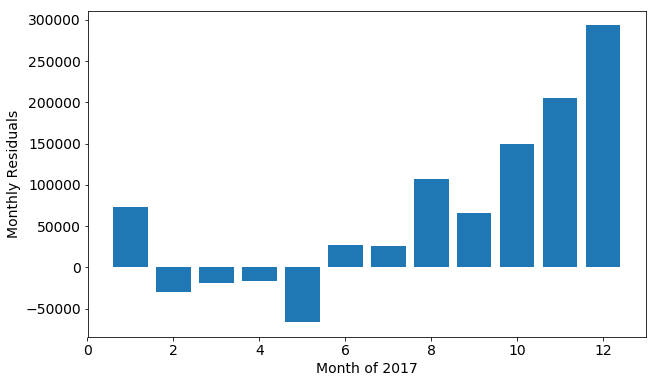

In [42]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11,12],monthly_residuals)
plt.xlabel('Month of 2017')
plt.ylabel('Monthly Residuals')

Text(0,0.5,'Monthly % Error')

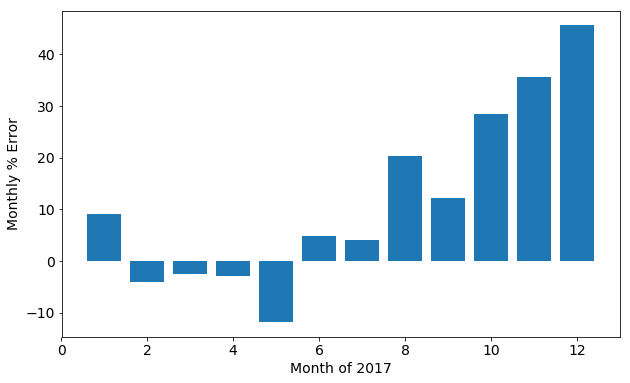

In [43]:
plt.bar([1,2,3,4,5,6,7,8,9,10,11,12],monthly_percent_off)
plt.xlabel('Month of 2017')
plt.ylabel('Monthly % Error')

In [34]:
# counting missing weather points
weather_data_used = weather_data['20130101':'20171231']
weather_data_used = pd.DataFrame(weather_data_used.temp, index=weather_data_used.index)
weather_data_null = weather_data_used[weather_data_used['temp'].isnull()]
weather_data_null = weather_data_null.fillna(0)
weather_data_null.groupby([weather_data_null.index.year,weather_data_null.index.month]).agg('count').head(60)
# lots of missing data, particularly in the early years, this may be part of issues found throughout the project

temp
dt   dt      
2013 1    145
     2     67
     3    132
     4     14
     5      3
     6     71
     7     34
     8    112
     9    287
     10   379
     11   147
     12    35
2014 1     32
     3      5
     4     38
     5     87
     6    403
     7    136
     8    616
     9    720
     10   744
     11   720
     12   744
2015 1    744
     2    672
     3    744
     4    720
     5    744
     6    573
     7      7
     8     14
     9     68
     10   255
     11   323
     12   305
2016 1    283
     2    187
     3    271
     4    121
     5     23
     6      7
     7      6
     8      1
     9      9
     10    19
     11     3
     12    17
2017 2     15
     3      4
     4      9
     7      6
     8      1
     9      4
     11     4
     12     4

In [40]:
weather_data_null.groupby([weather_data_null.index.month]).agg('count').head(12)

temp    11834
dtype: int64

In [35]:
# counting missing electricity points
bldg_data_0 = bldg_data[bldg_data['255_elec_use']==0]
bldg_data_0.groupby([bldg_data_0.index.year,bldg_data_0.index.month]).agg('count').head(100)
# lots of missing data in 2017, this may help explain why R2 dropped when used on 2017 data

255_elec_use
UTC_Datetime UTC_Datetime              
2013         3                        4
             11                       4
             12                      80
2014         5                      708
2015         1                       64
2016         11                     340
2017         6                      268
             8                      344
             9                        8
             10                      96
             12                     384

In [41]:
bldg_data_0.groupby([bldg_data_0.index.month]).agg('count').head(12)

255_elec_use    2300
dtype: int64

In [36]:
# I believe part of my issue may be caused by a lack of data integrity on both the weather and electricity usage datasets. 
# that's possibly why my R2 scored dropped between KFolds and the final test
# perhaps separate models for each month would be a better way of accounting for seasonality?

In [37]:
# Would it be reasonable to try and create a model to predict the HDD & CDD for 2018 then use those along with the known
# Sunlight and Workday features for 2018 as a feature set for 2018 to make forward predictions?
# Any better suggestions?

##### In the future, I'd like to try ensembling this model with a Random Forests Model

from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

##### list of values to try for n_estimators
estimator_range = range(10, 310, 10)

##### list to store the average RMSE for each value of n_estimators
RMSE_scores = []

##### use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

##### plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

rfreg = RandomForestRegressor(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X, y)

##### compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort('importance')